## Import Dependencies

In [281]:
import pandas as pd
import numpy as np
import psycopg2
import re
import config as creds
from pathlib import Path
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

## Connect to Postgres RDS

In [233]:
DATABASES = {
    'production':{
        'NAME': creds.PGDATABASE,
        'USER': creds.PGUSER,
        'PASSWORD': creds.PGPASSWORD,
        'HOST': creds.PGHOST,
        'PORT': 5432,
    },
}

#Choose the database to use
db = DATABASES['production']

In [234]:
#construct an engine connection string
engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = db['USER'],
    password = db['PASSWORD'],
    host = db['HOST'],
    port = db['PORT'],
    database = db['NAME'],
)

# create sqlalchemy engine
engine = create_engine(engine_string)

## Load Data

In [269]:
#Create tables from database into pandas dataframe
parks_df = pd.read_sql_table('parks', engine)
species_df = pd.read_sql_table('species', engine)
visitation_df = pd.read_sql_table('visitation', engine)

In [276]:
print(parks_df.shape)
parks_df.head()

(56, 6)


Park Code     object
Park Name     object
State         object
ACRES          int64
Latitude     float64
Longitude    float64
dtype: object

In [237]:
print(species_df.shape)
species_df.head()

(119248, 13)


,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurance,Nativeness,Abundance,Seasonality,Conservation Status
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,None
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,None,None
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,None,Species of Concern
3,ACAD-1003,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,None,None,Endangered
4,ACAD-1004,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,None


In [238]:
print(visitation_df.shape)
visitation_df.head()

(379, 12)


,Park Name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Average
0,Abraham Lincoln Birthplace NHP,177122.0,163568.0,169515.0,163928.0,241264.0,148605.0,252495.0,269580,260964,238226,208527
1,Acadia NP,2504208.0,2374645.0,2431052.0,2254922.0,2563129.0,2811184.0,3303393.0,3509271,3537575,3437286,2872667
2,Adams NHP,73339.0,219975.0,336031.0,285501.0,178468.0,183632.0,199301.0,255562,121007,187400,204022
3,African Burial Ground NM,117113.0,108585.0,77624.0,93234.0,54861.0,56348.0,46526.0,43182,45035,47427,68994
4,Agate Fossil Beds NM,12509.0,11617.0,11824.0,10504.0,12440.0,13264.0,15555.0,32038,16238,16657,15265


### Explore the Data

In [258]:
#Explore the types of data in the species dataframe
species_df['Abundance'].unique().tolist()

['Rare',
 'Abundant',
 'Common',
 None,
 'Uncommon',
 'Occasional',
 'Unknown',
 'Not Native',
 'Native']

In [259]:
#Describe the data columns in species_df
species_df.describe(include='all')

,Species ID,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurance,Nativeness,Abundance,Seasonality,Conservation Status
count,119248,119248,117776,117736,119248,119248,119248,99106,94203,76306,20157,4718
unique,119248,14,554,2332,46022,35825,54,7,5,8,24,11
top,GLAC-3389,Vascular Plant,Poales,Asteraceae,Falco peregrinus,None,Approved,Present,Native,Unknown,Breeder,Species of Concern
freq,1,65221,11453,8843,56,27147,86254,83278,75950,28119,12214,3843


In [261]:
#Describe the ACREAGE data from the parks database
parks_df.ACRES.describe()

count    5.600000e+01
mean     9.279291e+05
std      1.709258e+06
min      5.550000e+03
25%      6.901050e+04
50%      2.387645e+05
75%      8.173602e+05
max      8.323148e+06
Name: ACRES, dtype: float64

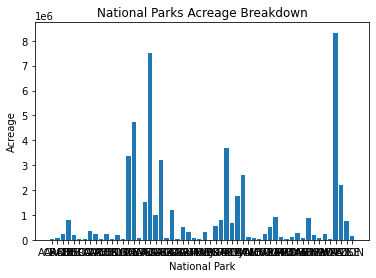

In [280]:
#Bar Chart showing acreage of parks
parks = parks_df['Park Code']
acreage = parks_df['ACRES']

x_pos = [i for i, _ in enumerate(parks)]
plt.bar(x_pos, acreage)
plt.xlabel("National Park")
plt.ylabel("Acreage")
plt.title("National Parks Acreage Breakdown")

plt.xticks(x_pos,parks)

plt.show()

In [282]:
#Explore binning the acreage of parks into four bins
pd.qcut(parks_df['ACRES'], q=4)

0        (5549.999, 69010.5]
1        (69010.5, 238764.5]
2      (238764.5, 817360.25]
3      (238764.5, 817360.25]
4        (69010.5, 238764.5]
5        (5549.999, 69010.5]
6        (5549.999, 69010.5]
7      (238764.5, 817360.25]
8      (238764.5, 817360.25]
9        (5549.999, 69010.5]
10     (238764.5, 817360.25]
11       (5549.999, 69010.5]
12       (69010.5, 238764.5]
13       (5549.999, 69010.5]
14    (817360.25, 8323148.0]
15    (817360.25, 8323148.0]
16       (5549.999, 69010.5]
17    (817360.25, 8323148.0]
18    (817360.25, 8323148.0]
19    (817360.25, 8323148.0]
20    (817360.25, 8323148.0]
21       (69010.5, 238764.5]
22    (817360.25, 8323148.0]
23       (5549.999, 69010.5]
24     (238764.5, 817360.25]
25     (238764.5, 817360.25]
26       (69010.5, 238764.5]
27       (5549.999, 69010.5]
28     (238764.5, 817360.25]
29       (5549.999, 69010.5]
30     (238764.5, 817360.25]
31     (238764.5, 817360.25]
32    (817360.25, 8323148.0]
33     (238764.5, 817360.25]
34    (817360.

## Transform Data

In [239]:
#Convert park names to list object from vistation dataframe
park_name_list = visitation_df.iloc[:,0]
park_name_list

0      Abraham Lincoln Birthplace NHP
1                           Acadia NP
2                           Adams NHP
3            African Burial Ground NM
4                Agate Fossil Beds NM
                    ...              
374                        Wupatki NM
375                    Yellowstone NP
376                       Yosemite NP
377        Yukon-Charley Rivers NPRES
378                           Zion NP
Name: Park Name, Length: 379, dtype: object

In [240]:
#Replace abbreviations in list
park_name_list = park_name_list.str.replace("Wrangell-St. Elias NP & PRES", "Wrangell - St Elias National Park and Preserve")
park_name_list = park_name_list.str.replace("Gates of the Arctic NP & PRES", "Gates Of The Arctic National Park and Preserve")
park_name_list = park_name_list.str.replace(" NP & PRES", " National Park and Preserve")
park_name_list = park_name_list.str.replace(" NPRES", " National Preserve")
park_name_list = park_name_list.str.replace(" NP", " National Park")
park_name_list = park_name_list.str.replace(" NM", " National Monument")
park_name_list = park_name_list.str.replace(" NHP", " National Historic Place")
park_name_list

C:\Users\ohugh\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


0      Abraham Lincoln Birthplace National Historic P...
1                                   Acadia National Park
2                          Adams National Historic Place
3                African Burial Ground National Monument
4                    Agate Fossil Beds National Monument
                             ...                        
374                            Wupatki National Monument
375                            Yellowstone National Park
376                               Yosemite National Park
377               Yukon-Charley Rivers National Preserve
378                                   Zion National Park
Name: Park Name, Length: 379, dtype: object

In [241]:
#Replace visitaiton_df "Park Name" column with updated park names
visitation_df["Park Name"] = park_name_list
visitation_df.head()

,Park Name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Average
0,Abraham Lincoln Birthplace National Historic P...,177122.0,163568.0,169515.0,163928.0,241264.0,148605.0,252495.0,269580,260964,238226,208527
1,Acadia National Park,2504208.0,2374645.0,2431052.0,2254922.0,2563129.0,2811184.0,3303393.0,3509271,3537575,3437286,2872667
2,Adams National Historic Place,73339.0,219975.0,336031.0,285501.0,178468.0,183632.0,199301.0,255562,121007,187400,204022
3,African Burial Ground National Monument,117113.0,108585.0,77624.0,93234.0,54861.0,56348.0,46526.0,43182,45035,47427,68994
4,Agate Fossil Beds National Monument,12509.0,11617.0,11824.0,10504.0,12440.0,13264.0,15555.0,32038,16238,16657,15265


In [242]:
#Append a row to the dataframe for Sequoia and Kings Canyon National Park
visitation_df.loc[len(visitation_df.index)] = ["Sequoia and Kings Canyon National Parks", 1573393, 1697617, 1476818, 1541405, 1565570, 1862167, 1984188, 1928617, 1878163, 1211163, 1671910]
visitation_df.tail()

,Park Name,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Average
375,Yellowstone National Park,3640185.0,3394326.0,3447729.0,3188030.0,3513484.0,4097710.0,4257177.0,4116524,4115000,4020288,3779045
376,Yosemite National Park,3901408.0,3951393.0,3853404.0,3691191.0,3882642.0,4150217.0,5028868.0,4336890,4009436,4422861,4122831
377,Yukon-Charley Rivers National Preserve,6211.0,1718.0,1393.0,3914.0,2329.0,1133.0,1146.0,952,1272,1114,2118
378,Zion National Park,2665972.0,2825505.0,2973607.0,2807387.0,3189696.0,3648846.0,4295127.0,4504812,4320033,4488268,3571925
379,Sequoia and Kings Canyon National Parks,1573393.0,1697617.0,1476818.0,1541405.0,1565570.0,1862167.0,1984188.0,1928617,1878163,1211163,1671910


In [243]:
# Set index on dataframes to Park Names
parks_df.set_index("Park Name", inplace=True, drop=True)
species_df.set_index("Park Name", inplace=True, drop=True)
visitation_df.set_index("Park Name", inplace=True, drop=True)

print(parks_df)
print(visitation_df)

                                               Park Code       State    ACRES  \
Park Name                                                                       
Acadia National Park                                ACAD          ME    47390   
Arches National Park                                ARCH          UT    76519   
Badlands National Park                              BADL          SD   242756   
Big Bend National Park                              BIBE          TX   801163   
Biscayne National Park                              BISC          FL   172924   
Black Canyon of the Gunnison National Park          BLCA          CO    32950   
Bryce Canyon National Park                          BRCA          UT    35835   
Canyonlands National Park                           CANY          UT   337598   
Capitol Reef National Park                          CARE          UT   241904   
Carlsbad Caverns National Park                      CAVE          NM    46766   
Channel Islands National Par

In [244]:
#Perform left join on parks df with visitaiton df
park_visitation_df = parks_df.join(visitation_df)
park_visitation_df

,Park Code,State,ACRES,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Average
Park Name,,,,,,,,,,,,,,,,
Acadia National Park,ACAD,ME,47390,44.35,-68.21,2504208.0,2374645.0,2431052.0,2254922.0,2563129.0,2811184.0,3303393.0,3509271,3537575,3437286,2872667
Arches National Park,ARCH,UT,76519,38.68,-109.57,1014405.0,1040758.0,1070577.0,1082866.0,1284767.0,1399247.0,1585718.0,1539028,1663557,1659702,1334063
Badlands National Park,BADL,SD,242756,43.75,-102.50,977778.0,870741.0,883406.0,892372.0,868094.0,989354.0,996263.0,1054325,1008942,970998,951227
Big Bend National Park,BIBE,TX,801163,29.25,-103.25,372330.0,361862.0,292055.0,316953.0,314102.0,381747.0,388290.0,440276,440091,463832,377154
Biscayne National Park,BISC,FL,172924,25.65,-80.08,467612.0,476077.0,495613.0,486848.0,525745.0,508164.0,514709.0,446961,469253,708522,509950
Black Canyon of the Gunnison National Park,BLCA,CO,32950,38.57,-107.72,176344.0,168336.0,192570.0,175852.0,183045.0,209166.0,238018.0,307143,308962,432818,239225
Bryce Canyon National Park,BRCA,UT,35835,37.57,-112.18,1285492.0,1296000.0,1385352.0,1311875.0,1435741.0,1745804.0,2365110.0,2571684,2679478,2594904,1867144
Canyonlands National Park,CANY,UT,337598,38.20,-109.93,435908.0,473773.0,452952.0,462242.0,542431.0,634607.0,776218.0,742271,739449,733996,599385
Capitol Reef National Park,CARE,UT,241904,38.20,-111.17,662661.0,668834.0,673345.0,663670.0,786514.0,941029.0,1064904.0,1150165,1227627,1226519,906527


In [245]:
#Check shape of dataframe
park_visitation_df.shape

(56, 16)

In [246]:
#Check for null values
park_visitation_df.isnull().sum()

Park Code    0
State        0
ACRES        0
Latitude     0
Longitude    0
2010         0
2011         0
2012         0
2013         0
2014         0
2015         0
2016         0
2017         0
2018         0
2019         0
Average      0
dtype: int64

In [247]:
#Count the number of native and non-native species for each park
species_grouped = species_df.groupby(['Park Name', 'Nativeness']).agg({'Nativeness': ['count']})
species_grouped.columns = ['Nativeness_count']
species_grouped = species_grouped.reset_index()
print(species_grouped)
print(type(species_grouped))

                  Park Name     Nativeness  Nativeness_count
0      Acadia National Park         Native              1189
1      Acadia National Park  Not Confirmed                 1
2      Acadia National Park     Not Native               485
3      Acadia National Park        Unknown                33
4      Arches National Park         Native               939
..                      ...            ...               ...
167  Yosemite National Park     Not Native               207
168  Yosemite National Park        Unknown                10
169      Zion National Park         Native              1591
170      Zion National Park     Not Native               203
171      Zion National Park        Unknown                 2

[172 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>


In [248]:
#Reshape dataframe and re-index to merge with main dataframe
nativeness_df = species_grouped.pivot(index='Park Name', columns='Nativeness')
nativeness_df.columns = nativeness_df.columns.droplevel()
nativeness_df

Nativeness,Native,Not Confirmed,Not Native,Present,Unknown
Park Name,,,,,
Acadia National Park,1189.0,1.0,485.0,NaN,33.0
Arches National Park,939.0,NaN,108.0,NaN,1.0
Badlands National Park,779.0,NaN,99.0,1.0,35.0
Big Bend National Park,2108.0,NaN,112.0,NaN,9.0
Biscayne National Park,751.0,NaN,241.0,1.0,620.0
Black Canyon of the Gunnison National Park,975.0,NaN,130.0,NaN,1.0
Bryce Canyon National Park,1186.0,NaN,98.0,NaN,2.0
Canyonlands National Park,1103.0,NaN,120.0,NaN,NaN
Capitol Reef National Park,1406.0,NaN,158.0,NaN,2.0


In [249]:
#Merge parks dataframe with species nativeness
combined_dataframe = park_visitation_df.join(nativeness_df)
combined_dataframe

#Replace NaN with 0
replace_null_df = combined_dataframe.replace(np.nan,0)
replace_null_df

,Park Code,State,ACRES,Latitude,Longitude,2010,2011,2012,2013,2014,...,2016,2017,2018,2019,Average,Native,Not Confirmed,Not Native,Present,Unknown
Park Name,,,,,,,,,,,,,,,,,,,,,
Acadia National Park,ACAD,ME,47390,44.35,-68.21,2504208.0,2374645.0,2431052.0,2254922.0,2563129.0,...,3303393.0,3509271,3537575,3437286,2872667,1189.0,1.0,485.0,0.0,33.0
Arches National Park,ARCH,UT,76519,38.68,-109.57,1014405.0,1040758.0,1070577.0,1082866.0,1284767.0,...,1585718.0,1539028,1663557,1659702,1334063,939.0,0.0,108.0,0.0,1.0
Badlands National Park,BADL,SD,242756,43.75,-102.50,977778.0,870741.0,883406.0,892372.0,868094.0,...,996263.0,1054325,1008942,970998,951227,779.0,0.0,99.0,1.0,35.0
Big Bend National Park,BIBE,TX,801163,29.25,-103.25,372330.0,361862.0,292055.0,316953.0,314102.0,...,388290.0,440276,440091,463832,377154,2108.0,0.0,112.0,0.0,9.0
Biscayne National Park,BISC,FL,172924,25.65,-80.08,467612.0,476077.0,495613.0,486848.0,525745.0,...,514709.0,446961,469253,708522,509950,751.0,0.0,241.0,1.0,620.0
Black Canyon of the Gunnison National Park,BLCA,CO,32950,38.57,-107.72,176344.0,168336.0,192570.0,175852.0,183045.0,...,238018.0,307143,308962,432818,239225,975.0,0.0,130.0,0.0,1.0
Bryce Canyon National Park,BRCA,UT,35835,37.57,-112.18,1285492.0,1296000.0,1385352.0,1311875.0,1435741.0,...,2365110.0,2571684,2679478,2594904,1867144,1186.0,0.0,98.0,0.0,2.0
Canyonlands National Park,CANY,UT,337598,38.20,-109.93,435908.0,473773.0,452952.0,462242.0,542431.0,...,776218.0,742271,739449,733996,599385,1103.0,0.0,120.0,0.0,0.0
Capitol Reef National Park,CARE,UT,241904,38.20,-111.17,662661.0,668834.0,673345.0,663670.0,786514.0,...,1064904.0,1150165,1227627,1226519,906527,1406.0,0.0,158.0,0.0,2.0


In [250]:
#Create field for total number of species and sum two previous columns in dataframe
replace_null_df['total_species'] = replace_null_df['Native'] + replace_null_df['Not Confirmed'] + replace_null_df['Not Native'] + replace_null_df['Present'] + replace_null_df['Unknown']
replace_null_df

,Park Code,State,ACRES,Latitude,Longitude,2010,2011,2012,2013,2014,...,2017,2018,2019,Average,Native,Not Confirmed,Not Native,Present,Unknown,total_species
Park Name,,,,,,,,,,,,,,,,,,,,,
Acadia National Park,ACAD,ME,47390,44.35,-68.21,2504208.0,2374645.0,2431052.0,2254922.0,2563129.0,...,3509271,3537575,3437286,2872667,1189.0,1.0,485.0,0.0,33.0,1708.0
Arches National Park,ARCH,UT,76519,38.68,-109.57,1014405.0,1040758.0,1070577.0,1082866.0,1284767.0,...,1539028,1663557,1659702,1334063,939.0,0.0,108.0,0.0,1.0,1048.0
Badlands National Park,BADL,SD,242756,43.75,-102.50,977778.0,870741.0,883406.0,892372.0,868094.0,...,1054325,1008942,970998,951227,779.0,0.0,99.0,1.0,35.0,914.0
Big Bend National Park,BIBE,TX,801163,29.25,-103.25,372330.0,361862.0,292055.0,316953.0,314102.0,...,440276,440091,463832,377154,2108.0,0.0,112.0,0.0,9.0,2229.0
Biscayne National Park,BISC,FL,172924,25.65,-80.08,467612.0,476077.0,495613.0,486848.0,525745.0,...,446961,469253,708522,509950,751.0,0.0,241.0,1.0,620.0,1613.0
Black Canyon of the Gunnison National Park,BLCA,CO,32950,38.57,-107.72,176344.0,168336.0,192570.0,175852.0,183045.0,...,307143,308962,432818,239225,975.0,0.0,130.0,0.0,1.0,1106.0
Bryce Canyon National Park,BRCA,UT,35835,37.57,-112.18,1285492.0,1296000.0,1385352.0,1311875.0,1435741.0,...,2571684,2679478,2594904,1867144,1186.0,0.0,98.0,0.0,2.0,1286.0
Canyonlands National Park,CANY,UT,337598,38.20,-109.93,435908.0,473773.0,452952.0,462242.0,542431.0,...,742271,739449,733996,599385,1103.0,0.0,120.0,0.0,0.0,1223.0
Capitol Reef National Park,CARE,UT,241904,38.20,-111.17,662661.0,668834.0,673345.0,663670.0,786514.0,...,1150165,1227627,1226519,906527,1406.0,0.0,158.0,0.0,2.0,1566.0


In [251]:
#Calculate the ratio of native to non-native species and add as a  column in the dataframe
replace_null_df['NonNative_Ratio'] = replace_null_df['Not Native'] / replace_null_df['total_species']
biodiversity_clean_df = replace_null_df
biodiversity_clean_df.head()

,Park Code,State,ACRES,Latitude,Longitude,2010,2011,2012,2013,2014,...,2018,2019,Average,Native,Not Confirmed,Not Native,Present,Unknown,total_species,NonNative_Ratio
Park Name,,,,,,,,,,,,,,,,,,,,,
Acadia National Park,ACAD,ME,47390,44.35,-68.21,2504208.0,2374645.0,2431052.0,2254922.0,2563129.0,...,3537575,3437286,2872667,1189.0,1.0,485.0,0.0,33.0,1708.0,0.283958
Arches National Park,ARCH,UT,76519,38.68,-109.57,1014405.0,1040758.0,1070577.0,1082866.0,1284767.0,...,1663557,1659702,1334063,939.0,0.0,108.0,0.0,1.0,1048.0,0.103053
Badlands National Park,BADL,SD,242756,43.75,-102.50,977778.0,870741.0,883406.0,892372.0,868094.0,...,1008942,970998,951227,779.0,0.0,99.0,1.0,35.0,914.0,0.108315
Big Bend National Park,BIBE,TX,801163,29.25,-103.25,372330.0,361862.0,292055.0,316953.0,314102.0,...,440091,463832,377154,2108.0,0.0,112.0,0.0,9.0,2229.0,0.050247
Biscayne National Park,BISC,FL,172924,25.65,-80.08,467612.0,476077.0,495613.0,486848.0,525745.0,...,469253,708522,509950,751.0,0.0,241.0,1.0,620.0,1613.0,0.149411


### Correlation Exploration

In [252]:
biodiversity_clean_df.corr(method='pearson')

,ACRES,Latitude,Longitude,2010,2011,2012,2013,2014,2015,2016,...,2018,2019,Average,Native,Not Confirmed,Not Native,Present,Unknown,total_species,NonNative_Ratio
ACRES,1.000000,0.587785,-0.494390,-0.110810,-0.112268,-0.108780,-0.106010,-0.109455,-0.109432,-0.116217,...,-0.107323,-0.104959,-0.110828,0.056391,-0.089483,-0.203330,-0.079655,-0.025063,-0.042422,-0.327195
Latitude,0.587785,1.000000,-0.492102,-0.158308,-0.163358,-0.164803,-0.156387,-0.166950,-0.168670,-0.165332,...,-0.146449,-0.155043,-0.161727,-0.161619,-0.029330,-0.502744,-0.057592,-0.011457,-0.292493,-0.580574
Longitude,-0.494390,-0.492102,1.000000,0.241932,0.233288,0.236172,0.226202,0.225362,0.219129,0.217777,...,0.230908,0.239784,0.229916,0.061266,0.131481,-0.025277,0.068420,0.163458,0.098498,0.165062
2010,-0.110810,-0.158308,0.241932,1.000000,0.997745,0.998391,0.996825,0.996661,0.993844,0.989627,...,0.978453,0.982533,0.994788,0.612595,-0.034413,0.264549,-0.045630,0.106597,0.558449,0.160192
2011,-0.112268,-0.163358,0.233288,0.997745,1.000000,0.998123,0.997377,0.997353,0.996093,0.992651,...,0.980212,0.983326,0.995992,0.604697,-0.036126,0.262926,-0.042298,0.111647,0.554418,0.158340
2012,-0.108780,-0.164803,0.236172,0.998391,0.998123,1.000000,0.998181,0.998805,0.996452,0.992363,...,0.981230,0.987073,0.996973,0.608819,-0.038235,0.273695,-0.043626,0.102309,0.557352,0.166468
2013,-0.106010,-0.156387,0.226202,0.996825,0.997377,0.998181,1.000000,0.998866,0.995976,0.991443,...,0.980964,0.985510,0.996459,0.614335,-0.042774,0.266840,-0.046311,0.087321,0.552865,0.156169
2014,-0.109455,-0.166950,0.225362,0.996661,0.997353,0.998805,0.998866,1.000000,0.997649,0.993485,...,0.983825,0.988714,0.997850,0.609718,-0.039432,0.277329,-0.044230,0.093828,0.555904,0.168859
2015,-0.109432,-0.168670,0.219129,0.993844,0.996093,0.996452,0.995976,0.997649,1.000000,0.997037,...,0.990138,0.991020,0.998925,0.612315,-0.039527,0.266617,-0.040824,0.109345,0.560090,0.154947
2016,-0.116217,-0.165332,0.217777,0.989627,0.992651,0.992363,0.991443,0.993485,0.997037,1.000000,...,0.993285,0.992913,0.998062,0.608413,-0.031468,0.251608,-0.039842,0.094411,0.546285,0.143715


### Linear Regression Model Testing

#### Park Visitation and The Ratio of Non-Native to Native Species

In [215]:
X = biodiversity_clean_df.Average.values.reshape(-1,1)

In [216]:
y = biodiversity_clean_df['Not Native'].values.reshape(-1,1)

In [217]:
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
print(y_pred.shape)

(56, 1)


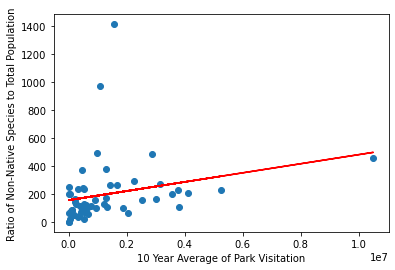

In [222]:
plt.scatter(X,y)
plt.plot(X, y_pred, color='red')
plt.xlabel('10 Year Average of Park Visitation')
plt.ylabel('Ratio of Non-Native Species to Total Population')
plt.show()

In [219]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y, y_pred)

48110.84675437026

In [221]:
from sklearn import metrics
metrics.r2_score(y, y_pred)

0.06277162361411592

#### Park Size and Total Number of Species

In [226]:
X = biodiversity_clean_df.ACRES.values.reshape(-1,1)
y = biodiversity_clean_df.total_species.values.reshape(-1,1)

In [227]:
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
print(y_pred.shape)

(56, 1)


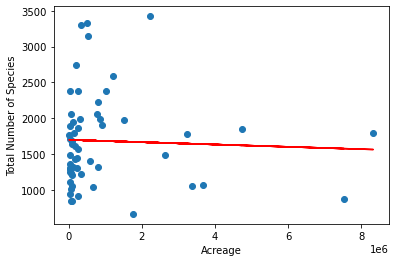

In [228]:
plt.scatter(X,y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Acreage')
plt.ylabel('Total Number of Species')
plt.show()

In [231]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y, y_pred)
print(mean_squared_error(y, y_pred))
from sklearn import metrics
metrics.r2_score(y, y_pred)
print(metrics.r2_score(y, y_pred))

420296.3878579953
0.0017996125255190787
